# Greater London Shapefile
51.5074° N, 0.1278° W

http://geopandas.org/reference.html

In [1]:
%matplotlib inline 
from matplotlib import pyplot as plt
import geopandas as gpd
from geopy.distance import great_circle
data = gpd.read_file("DL/gis_osm_roads_free_1.shp")

In [2]:
exclude = ["footway","cycleway","path","steps","bridleway"]
data = data[~data.fclass.isin(exclude)]

# Reduce bounding box
top right
51.562745, -0.105098

bottom left:
51.513559, -0.172893

In [3]:
import folium
#https://medium.com/@rohanguptha.bompally/python-data-visualization-using-folium-and-geopandas-981857948f02
bb = folium.Map(location=[ 51.562745, -0.105098], zoom_start=12)
top_right = (51.562745, -0.105098)
bottom_left = (51.513559, -0.172893)
top_left = (bottom_left[0],top_right[1])
bottom_right = (top_right[0],bottom_left[1]) 
bb.add_child(folium.PolyLine([top_right,bottom_right,bottom_left,top_left,top_right],weight=5,color="blue"))
bb

In [4]:
import tqdm
relevant = []
for i, x in tqdm.tqdm(data.iterrows()):
    oid = x.osm_id
    geo = x.geometry
    coords = geo.coords
    if any(-0.1778849<=x<=-0.105098 and 51.513559<=y<=51.562745 for x,y in coords):
        relevant.append(oid)
len(relevant)

182181it [01:15, 2424.38it/s]


8295

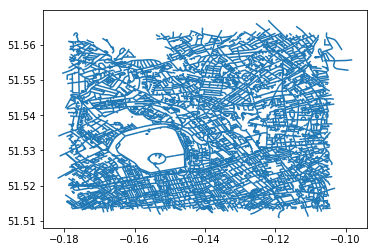

In [5]:
camden = data[data.osm_id.isin(relevant)]
camden.plot()

# Match lamps

In [331]:
import pandas as pd

lamps = pd.read_csv('lamp_position.txt', header = None)
lamps.columns = ["lon","lat"]
lamps.head()

,lon,lat
0,-0.110930,51.517002
1,-0.124733,51.521688
2,-0.125968,51.521937
3,-0.126737,51.521690
4,-0.125192,51.521578


In [336]:
gdf = gpd.GeoDataFrame(lamps, geometry=gpd.points_from_xy(lamps.lon, lamps.lat))
gdf.head()

,lon,lat,geometry
0,-0.110930,51.517002,POINT (-0.11093 51.51700)
1,-0.124733,51.521688,POINT (-0.12473 51.52169)
2,-0.125968,51.521937,POINT (-0.12597 51.52194)
3,-0.126737,51.521690,POINT (-0.12674 51.52169)
4,-0.125192,51.521578,POINT (-0.12519 51.52158)


In [339]:
match = []
for i, x in tqdm.tqdm(gdf.iterrows()):
    dist = []
    lamp_geo = x.geometry
    for j,y in camden.iterrows():
        dist.append((lamp_geo.distance(y.geometry),y.osm_id))
    dist = sorted(dist)
    match.append(dist[0][1])

327it [16:53,  3.10s/it]


In [340]:
file = open("lamp_match.txt","w")#write mode
for pos in match:
    file.write(str(pos))
    file.write("\n") 
file.close()

In [ ]:
camden["lamps"] = 0

# Match parking spots to streets

In [6]:
from shapely.geometry import Point,LineString
f = open("camdenParkingBays.txt","r").read().splitlines()
match = []
for l in tqdm.tqdm(f):
    l = l.replace("[","").replace("]","").replace(",","")
    l = l.split()
    line = LineString([(float(l[2]),float(l[1])),(float(l[4]),float(l[3]))])
    centr = line.centroid
    spot_id = l[0]
    dist = []
    for j,y in camden.iterrows():
        dist.append((centr.distance(y.geometry),y.osm_id))
    dist = sorted(dist)
    match.append((spot_id,)+dist[0])

  0%|▎                                                                                 | 2/576 [00:06<29:43,  3.11s/it]


KeyboardInterrupt: 

In [354]:
match[0]

('0', 1.7369455938046645e-05, '732486470')

In [357]:
file = open("park_match.txt","w")#write mode
for pos in match:
    file.write(pos[0] + "," +pos[2])
    file.write("\n") 
file.close()

## Read from file

In [8]:
f = open("park_match.txt","r").read().splitlines()
j = open("crimeScoring.txt.txt","r").read().splitlines()
len(f),len(j)

(576, 576)

In [12]:
camden["parking"] = 0
camden["safety"] = 0
for x in range(len(f)):
    osm_id = f[0].split(",")[1]
    safety = float(j[x].split()[-1][:-1])
    camden.loc[camden.osm_id==osm_id, 'parking'] += 1

C:\Users\Max Hort\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Max Hort\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Max Hort\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [367]:
camden["parking"] = 0
camden["safety"] = 0
for p,dist,osm_id in match:
    camden.loc[camden.osm_id==osm_id, 'parking'] += 1
    #camden[camden.osm_id == osm_id].parking += 1
camden.head()

C:\Users\Max Hort\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Max Hort\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,len,time,parking
186,31030,5112,trunk,Grafton Way,A400,F,32,0,F,F,"LINESTRING (-0.13493 51.52457, -0.13499 51.524...",0.247223,0.007492,0
187,31039,5113,primary,Tottenham Court Road,A400,F,48,0,F,F,"LINESTRING (-0.13038 51.51641, -0.13038 51.516...",0.079399,0.001620,0
188,31959,5115,tertiary,Cleveland Street,None,F,48,0,F,F,"LINESTRING (-0.13910 51.52083, -0.13915 51.520...",0.097558,0.001991,0
246,330341,5112,trunk,Penton Rise,A201,F,48,0,F,F,"LINESTRING (-0.11412 51.53137, -0.11411 51.531...",0.246705,0.005035,0
247,330437,5113,primary,St. John Street,A401,B,32,0,F,F,"LINESTRING (-0.10627 51.53191, -0.10623 51.531...",0.018785,0.000569,0


## Oneway
- F -> oneway
- T -> opposite
- B -> both

In [9]:
data["len"] = data.geometry.length*100
data["time"] = data.len/(data.maxspeed+1)

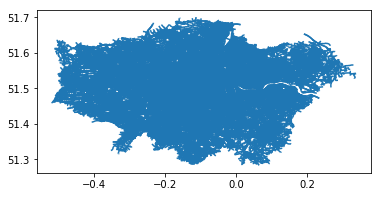

In [3]:
data.plot()

In [543]:
camden[0:1]

,osm_id,code,fclass,name,ref,oneway,maxspeed,layer,bridge,tunnel,geometry,len,time,parking
186,31030,5112,trunk,Grafton Way,A400,F,32,0,F,F,"LINESTRING (-0.13493 51.52457, -0.13499 51.524...",0.247223,0.007492,0


In [444]:
import networkx as nx
def reverse_coords(c):
    return [(y,x) for x,y in c]

G = nx.Graph()
for i,x in camden.iterrows():
    l = x.len
    osm_id = x.osm_id
    time = x.time
    parking = x.parking
    safety = 0
    coords = list(x.geometry.coords)
    coords = reverse_coords(coords)
    start,end = coords[0],coords[-1]
    oneway = x.oneway
    if oneway == "F" and False:
        G.add_edge(start,end,length=l,time=time,parking=parking,safety=safety,oid=osm_id)
    elif oneway == "T" and False:
        G.add_edge(end,start,length=l,time=time,parking=parking,safety=safety,oid=osm_id)
    else:
        G.add_edge(start,end,length=l,time=time,parking=parking,safety=safety,oid=osm_id)
        G.add_edge(end,start,length=l,time=time,parking=parking,safety=safety,oid=osm_id)
coords

[(51.5331283, -0.1068954), (51.5329672, -0.1069195)]

In [376]:
len(G)

10324

# Routing basic

In [276]:
from geopy.distance import great_circle
from numpy.random import choice
import numpy as np
# draw = choice(list_of_candidates, number_of_items_to_pick,
#               p=probability_distribution)

In [197]:
import random
start = (51.612284, -0.1778849)
target = (51.58702,-0.39460)
target = (51.5971222, -0.1979855) 

In [508]:
def random_run(graph, start, target,limit = 2500,by_distance=True):
    current = start
    path = [current]
    while current != target:
        if by_distance:
            keys = list(graph[current].keys())
            dist = np.array([great_circle(target,k).kilometers for k in keys])
            worst = max(dist)*1.01
            dist = worst-dist
            n = choice([x for x in range(len(keys))], 1,p=dist/sum(dist))[0]
            n = keys[n]
        else:
            n = random.choice(list(graph[current].keys()))
        path.append(n)
        current = n
        if len(path)>limit:
            return
    return path

In [533]:
def compute_scores(graph,path):
    time = 0
    length = 0
    complexity = 0
    parking = 0
    safety = 0
    seen_parking = set()
    for u,v in zip(path[:-1],path[1:]):
        
        e = graph[u][v]
        time += e["time"]
        length += e["length"]
        complexity+=1
        u,v = min(u,v),max(u,v)
        if (u,v) not in seen_parking:
            parking += e["parking"]
            seen_parking.add((u,v))
        safety += e["safety"]
    return [time,length,complexity,parking,safety]

In [440]:
def get_routes(graph,start,target,runs):
    scores = []
    for _ in range(runs):
        if _%100 == 0 and _>0:
            print (_)
        path = random_run(graph,start,target)
        if path:
            s = compute_scores(graph,path)
            scores.append([path]+s)
    return scores

In [305]:
routes = get_routes(G,start,target,10)

In [306]:
len(routes)

10

# Visualize Routes

In [252]:
def reverse_coords(coords):
    return [(y,x) for x,y in coords]
def get_lines_from_path(graph,path):
    ids = get_ids_from_path(graph,path)
    rows = data[data.osm_id.isin(ids)]
    lines = []
    for i,x in rows.iterrows():
        geom = x.geometry
        coords = geom.coords
        reverted = reverse_coords(coords)
        lines.append(reverted)
    return lines
def get_ids_from_path(graph,path):
    ids = set()
    for a, b in zip(path[:-1],path[1:]):
        oid = graph[a][b]["oid"]
        ids.add(oid)
    return ids

In [258]:
#[time,length,complexity,parking,safety]
shortest = sorted(routes, key = lambda x: x[0][0],reverse = False)[0]
quickest = sorted(routes, key = lambda x: x[0][1],reverse = False)[0]
easiest = sorted(routes, key = lambda x: x[0][2],reverse = False)[0]
parking = sorted(routes, key = lambda x: x[0][3],reverse = True)[0]
safety = sorted(routes, key = lambda x: x[0][4],reverse = True)[0]
# easiest

In [259]:
lines_easy = get_lines_from_path(G,easiest[0])
lines_special = get_lines_from_path(G,special[0])

In [ ]:
start = (51.612284, -0.1778849)
target = (51.58702,-0.39460)
target = (51.5971222, -0.1979855)

In [261]:
import folium
#https://medium.com/@rohanguptha.bompally/python-data-visualization-using-folium-and-geopandas-981857948f02
m = folium.Map(location=[ 51.61228,-0.17788], zoom_start=12)
folium.CircleMarker(start, popup="Start",color ="green").add_to(m)
folium.CircleMarker(target, popup="Target",color = "red").add_to(m)
for l in lines_easy:
    m.add_child(folium.PolyLine(l,weight=3,color="red"))
    
for l in lines_special:
    m.add_child(folium.PolyLine(l,weight=3,color="green"))
# a = (51.61228, -0.17788)
# b = (51.61235, -0.17785 )
# points = [a,b]
# my_PolyLine=folium.PolyLine(points,weight=5,color="red")
# m.add_child(my_PolyLine)
m

# Get Start and Target Address

In [370]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="specify_your_app_name_here")
location = geolocator.geocode("Manchester Street, London")

In [457]:
#user_start = geolocator.geocode("Falkland Road, London")
#user_start = geolocator.geocode("Kentish Town West, London")
user_start = geolocator.geocode("Drayton Park, London")
#user_destination = geolocator.geocode("Manchester Street, London")
#user_destination = geolocator.geocode("Kentish Town, London")
user_destination = geolocator.geocode("Cleveland Terrace, London")

In [459]:
start_coords = [user_start.latitude,user_start.longitude]
dest_coords = [user_destination.latitude,user_destination.longitude]
start_coords,dest_coords

([51.5469937, -0.1467554], [51.5480094, -0.1494918])

In [492]:
start_coords = (51.5512835, -0.1087542)
dest_coords = (51.5173866, -0.1797734)
a = start_coords
b = dest_coords

In [490]:
paths[-1][0],paths[-1][1]

((51.5512835, -0.1087542), (51.5173866, -0.1797734))

## Get closest node to position

In [460]:
a = None
dist = []
for n in G.nodes():
    dist.append((great_circle(start_coords,n),n))
dist = sorted(dist)
a = dist[0][1]
dist[0]

(Distance(0.010353206581998273), (51.5469302, -0.1468649))

In [484]:
paths = []
for x in range(20000):
    node1 = random.choice(G.nodes())
    node2 = random.choice(G.nodes())
    if node1 == node2:
        continue
    try:
        p = nx.shortest_path(G,node1,node2)
        d = nx.shortest_path_length(G,node1,node2)
        paths.append((node1,node2,p,d))
    except:
        pass
len(paths)

2359

In [486]:
paths = sorted(paths, key = lambda x: len(x[2]))

In [461]:
b = None
dist = []
for n in G.nodes():
    dist.append((great_circle(dest_coords,n),n))
dist = sorted(dist)
b = dist[0][1]
dist[0]

(Distance(0.0), (51.5480094, -0.1494918))

In [544]:
paths[i][1],paths[i][0]

((51.5466933, -0.1283717), (51.5262345, -0.1073725))

In [ ]:
a = (51.5466933, -0.1283717)
b = (51.5262345, -0.1073725)

In [538]:
routes = get_routes(G,paths[i][1],paths[i][0],2500)
len(routes)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400


2138

In [ ]:
parking = sorted(routes, key = lambda x: x[0][3],reverse = True)[0]
lines_parking = get_lines_from_path(G,parking[0])
for l in lines_parking:
    m.add_child(folium.PolyLine(l,weight=3,color="red"))


In [549]:
parking = sorted(routes, key = lambda x: x[4],reverse = True)

In [541]:
len(parking[0][0]),parking[0][1],parking[0][2],parking[0][3]

(2500, 12.510903922277341, 147.61446480366925, 2499)

In [522]:
routes[1][1],routes[1][2],routes[1][3],routes[1][4]

(0.2540651643082454, 8.06694639004583, 82, 0)

In [548]:
compute_scores(G,parking[0][0])

[12.510903922277341, 147.61446480366925, 2499, 0, 0]

In [551]:
for x in parking[:10]:
    print (x[4])

8
7
7
5
5
5
5
4
4
4


## Visualize

In [552]:
import folium
map_camden = folium.Map(location=[ 51.562745, -0.105098], zoom_start=12)
top_right = (51.562745, -0.105098)
bottom_left = (51.513559, -0.172893)
bottom_left = (51.513559, -0.172893)
top_left = (bottom_left[0],top_right[1])
bottom_right = (top_right[0],bottom_left[1]) 
map_camden.add_child(folium.PolyLine([top_right,bottom_right,bottom_left,top_left,top_right],weight=5,color="blue"))
#folium.CircleMarker(a, popup="Start",color ="blue").add_to(map_camden)
#folium.CircleMarker(b, popup="Target",color = "red").add_to(map_camden)

i = -1000

folium.CircleMarker(paths[i][0], popup="Start",color ="red").add_to(map_camden)
folium.CircleMarker(paths[i][1], popup="Target",color = "blue").add_to(map_camden)

short = []
for p1,p2 in zip(paths[i][2][:-1],paths[i][2][1:]):
    short.append((p1,p2))
map_camden.add_child(folium.PolyLine(short,weight=3,color="red"))
# lines_easy = get_lines_from_path(G,routes[0])
# for l in lines_easy:
#     map_camden.add_child(folium.PolyLine(l,weight=3,color="red"))
parking = sorted(routes, key = lambda x: x[4],reverse = True)[0]
lines_parking = get_lines_from_path(G,parking[0])
for l in lines_parking:
    map_camden.add_child(folium.PolyLine(l,weight=3,color="blue"))


f = open("camdenParkingBays.txt","r").read().splitlines()
match = []
for l in f:
    if len(l)<10:continue
    l = l.replace("[","").replace("]","").replace(",","")
    l = l.split()
    #line = LineString([(float(l[2]),float(l[1])),(float(l[4]),float(l[3]))])
    a_,b_,c_,d_ =float(l[1]),float(l[2]),float(l[3]),float(l[4])
    map_camden.add_child(folium.PolyLine([(a_,b_),(c_,d_)],weight=5,color="green"))
map_camden